In [ ]:
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.motors.feetech import FeetechMotorsBus
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera

import numpy as np

follower_arm = {
    "main": FeetechMotorsBus(
        port="COM7",
        motors={
            # name: (index, model)
            "shoulder_pan": (1, "sts3215"),
            "shoulder_lift": (2, "sts3215"),
            "elbow_flex": (3, "sts3215"),
            "wrist_flex": (4, "sts3215"),
            "wrist_roll": (5, "sts3215"),
            "gripper": (6, "sts3215"),
        },
    ),
}

cameras={"laptop": OpenCVCamera(2, fps=30, width=640, height=480), "phone": OpenCVCamera(1, fps=30, width=640, height=480)}


robot = ManipulatorRobot(
    robot_type="so100",
    # leader_arms={"main": leader_arm},
    follower_arms=follower_arm,
    cameras=cameras,
    calibration_dir=".cache\calibration\so100"
)

robot.connect()
follower_pos = robot.follower_arms["main"].read("Present_Position")
print(follower_pos)

In [2]:
# Home Position
home = np.array([1.40625, 187.99805, 177.89062, 65.83008, 0, 0])
robot.follower_arms["main"].write("Goal_Position", home)

In [ ]:
goal = follower_pos
goal[0] = 0
goal[1] = 0
goal[2] = 0
goal[3] = 0
goal[4] = 0
goal[5] = 0
print(goal)

robot.follower_arms["main"].write("Goal_Position", goal)

In [ ]:
goal = follower_pos
goal[0] = 0
goal[1] = 90
goal[2] = 90
goal[3] = 90
goal[4] = 0
goal[5] = 0
print(goal)

robot.follower_arms["main"].write("Goal_Position", goal)

In [ ]:
follower_pos = robot.follower_arms["main"].read("Present_Position")
print(follower_pos)

In [12]:
robot.disconnect()

In [ ]:
robot.follower_arms['main'].write()

In [ ]:
robot.follower_arms['main'].are_motors_configured()

In [ ]:
robot.follower_arms['main'].motor_indices

In [ ]:
robot.follower_arms['main'].motor_models

In [ ]:
robot.follower_arms['main'].read_with_motor_ids(motor_models=robot.follower_arms['main'].motor_models, motor_ids=2, data_name='Present_Position')

In [22]:
robot.follower_arms['main'].disconnect()

In [ ]:
from datasets import load_dataset

ds = load_dataset("lerobot/berkeley_cable_routing")

In [ ]:
ds

# Camera

(480, 640, 3)
uint8


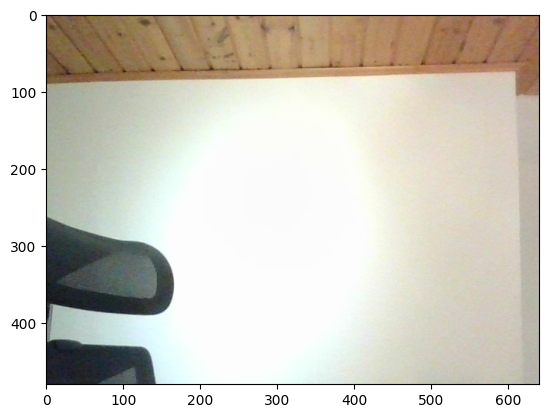

In [1]:
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
import matplotlib.pyplot as plt 
camera = OpenCVCamera(camera_index=2, fps=30, width=640, height=480)
camera.connect()
color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)
plt.imshow(color_image)

camera.disconnect()

(480, 640, 3)
uint8


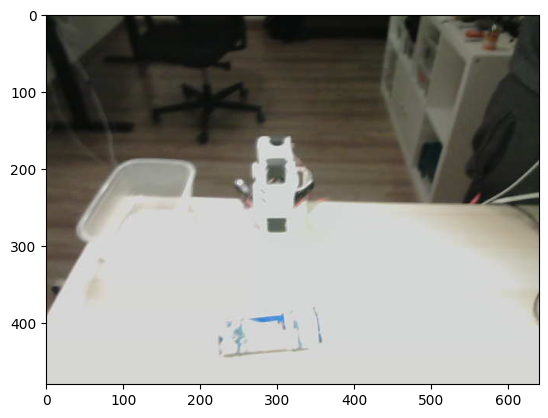

In [2]:
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
import matplotlib.pyplot as plt 
camera = OpenCVCamera(camera_index=0, fps=30, width=640, height=480)
camera.connect()
color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)
plt.imshow(color_image)

camera.disconnect()

(480, 640, 3)
uint8


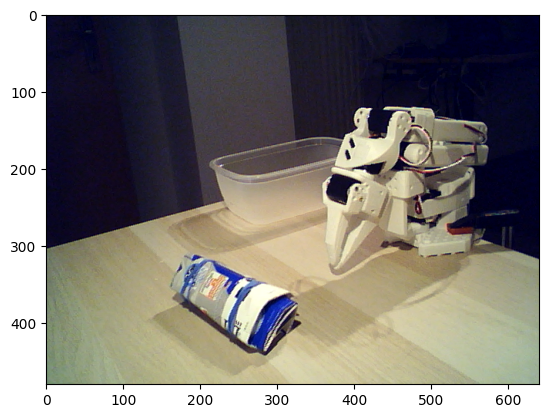

In [3]:
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
import matplotlib.pyplot as plt 
camera = OpenCVCamera(camera_index=1, fps=30, width=640, height=480)
camera.connect()
color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)
plt.imshow(color_image)

camera.disconnect()

(480, 640, 3)
uint8


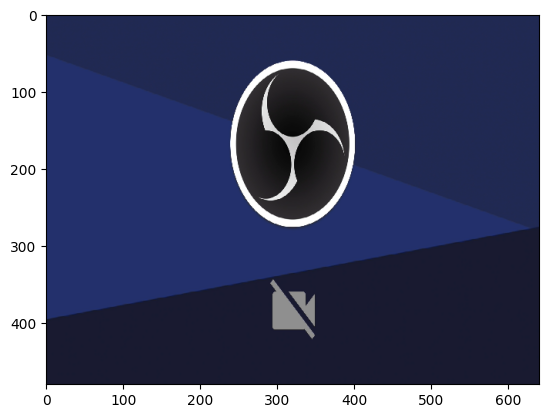

In [4]:
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
import matplotlib.pyplot as plt 
camera = OpenCVCamera(camera_index=3, fps=30, width=640, height=480)
camera.connect()
color_image = camera.read()

print(color_image.shape)
print(color_image.dtype)
plt.imshow(color_image)

camera.disconnect()

# Simulation

## Check Cams

In [ ]:
observation = robot.capture_observation()
print(observation.keys())
print(observation['observation.state'])
plt.imshow(observation['observation.images.phone'])

In [ ]:
observation = robot.capture_observation()
print(observation.keys())
print(observation['observation.state'])
plt.imshow(observation['observation.images.laptop'])

# Inference

In [ ]:
from lerobot.common.policies.act.modeling_act import ACTPolicy
from lerobot.common.robot_devices.robots.manipulator import ManipulatorRobot
from lerobot.common.robot_devices.motors.feetech import FeetechMotorsBus
from lerobot.common.robot_devices.cameras.opencv import OpenCVCamera
from lerobot.scripts.control_robot import busy_wait
import matplotlib.pyplot as plt 
import time
import torch
import numpy as np
import gymnasium as gym
import gym_so100

# Create the environment
env = gym.make("gym_so100/PushCube-v0", render_mode="human")
# Reset the environment
_, info = env.reset()
_, reward, terminted, truncated, info = env.step(np.array([0, 0, 0, 0, 0, 0]))

follower_arm = {
    "main": FeetechMotorsBus(
        port="COM7",
        motors={
            # name: (index, model)
            "shoulder_pan": (1, "sts3215"),
            "shoulder_lift": (2, "sts3215"),
            "elbow_flex": (3, "sts3215"),
            "wrist_flex": (4, "sts3215"),
            "wrist_roll": (5, "sts3215"),
            "gripper": (6, "sts3215"),
        },
    ),
}

cameras={"laptop": OpenCVCamera(2, fps=30, width=640, height=480), "phone": OpenCVCamera(1, fps=30, width=640, height=480)}


robot = ManipulatorRobot(
    robot_type="so100",
    # leader_arms={"main": leader_arm},
    follower_arms=follower_arm,
    cameras=cameras,
    calibration_dir=".cache\calibration\so100"
)

robot.connect()

# Model
inference_time_s = 60
fps = 30
device = "cpu"  # TODO: On Mac, use "mps" or "cpu"
ckpt_path = 'pranavsaroha/act_so100_squishy100'
policy = ACTPolicy.from_pretrained(ckpt_path)
policy.to(device)

observation = robot.capture_observation()
print(observation.keys())



for _ in range(inference_time_s * fps):
    start_time = time.perf_counter()

    # Read the follower state and access the frames from the cameras
    observation = robot.capture_observation()
    
    # Convert to pytorch format: channel first and float32 in [0,1]
    # with batch dimension
    for name in observation:
        if "image" in name:
            observation[name] = observation[name].type(torch.float32) / 255
            observation[name] = observation[name].permute(2, 0, 1).contiguous()
        observation[name] = observation[name].unsqueeze(0)
        observation[name] = observation[name].to(device)

    # Compute the next action with the policy
    # based on the current observation
    action = policy.select_action(observation)
    # Remove batch dimension
    action = action.squeeze(0)
    # Move to cpu, if not already the case
    action = action.to("cpu")
    print(f"Observation: {observation['observation.state']}, Action: {action}")
    # Order the robot to move
    robot.send_action(action)
    ##############################################
    # Gym
    absolute_action = observation['observation.state'].reshape(-1) - action
    _, reward, terminted, truncated, info = env.step(absolute_action)
    
    
    ###################
    dt_s = time.perf_counter() - start_time
    busy_wait(1 / fps - dt_s)


robot.disconnect()

In [ ]:
observation['observation.state'].reshape(-1)

In [ ]:
action

In [ ]:
observation['observation.state'].reshape(-1) - action

In [ ]:
!python lerobot/scripts/control_robot.py teleoperate --robot-path lerobot/configs/robot/so100-ps4.yaml

In [ ]:
from lerobot.common.robot_devices.controllers.joysticks import PS4JoystickController

In [ ]:
import hid

for device in hid.enumerate():
    print(device)

In [ ]:
import hid

for device in hid.enumerate():
    print(device)


In [ ]:
!python lerobot/scripts/control_robot.py record --robot-path lerobot/configs/robot/so100-ps4.yaml --fps 30 --push-to-hub 0 --tags tutorial --warmup-time-s 10 --episode-time-s 30 --reset-time-s 30 --num-episodes 2 --single-task 'Pickup the object and put it in the box'